In [51]:
#Levitation height distribution extraction analysis
#Last updated 17 April 2021.
#Author: Shreya Deshmukh, Stanford University.

#Runs as a jupyter notebook through anaconda (on python version 2.7)

#Import the following libraries
from os import listdir
from os.path import join
import numpy as np
import scipy.misc
from scipy import ndimage

from scipy import stats
from scipy.stats import moment, mode
import csv
import matplotlib.pyplot as plt
import cv2
import os.path
from PIL import Image
import skimage
from skimage.transform import resize
from scipy.signal import savgol_filter
%matplotlib inline

plt.rc('font',family='Arial')

#Define file path
#path = 'C:\\Users\\yourefiledirectories' #input the file path to where images are stored in the directory

os.listdir(path)

['Snap-24.czi',
 'Snap-24_c1+2.tif',
 'Snap-24_c1.tif',
 'Snap-24_c2.tif',
 'Snap-25.czi',
 'Snap-25_c1+2.tif',
 'Snap-25_c1.tif',
 'Snap-25_c2.tif',
 'Snap-26.czi',
 'Snap-26_c1+2.tif',
 'Snap-26_c1.tif',
 'Snap-26_c2.tif',
 'Snap-27.czi',
 'Snap-27_c1+2.tif',
 'Snap-27_c1.tif',
 'Snap-27_c2.tif',
 'Snap-28.czi',
 'Snap-28_c1+2.tif',
 'Snap-28_c1.tif',
 'Snap-28_c2.tif',
 'Snap-29.czi',
 'Snap-29_c1+2.tif',
 'Snap-29_c1.tif',
 'Snap-29_c2.tif',
 'Snap-30.czi',
 'Snap-30_c1+2.tif',
 'Snap-30_c1.tif',
 'Snap-30_c2.tif',
 'Snap-31.czi',
 'Snap-31_c1+2.tif',
 'Snap-31_c1.tif',
 'Snap-31_c2.tif',
 'Snap-32.czi',
 'Snap-32_c1+2.tif',
 'Snap-32_c1.tif',
 'Snap-32_c2.tif']

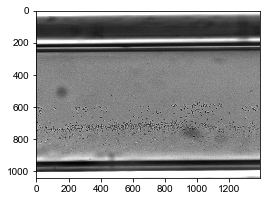

In [76]:
#(Start here if processing raw (uncropped) images. If pre-cropped images available, scroll down to the next "Import" stage.)
#Insert your filename here
img_title = "Snap-31_c1"

#Import image as RGB
img_bf = cv2.imread(os.path.join(path, img_title + ".tif")) #use the relevant file extension here
#resized = img_disp

#Convert from RGB to grey using OpenCV inbuilt command -brightfield
grey = cv2.cvtColor(img_bf, cv2.COLOR_BGR2GRAY)
plt.figure(figsize = (4,4))
plt.imshow(grey, cmap = plt.get_cmap('gray'))

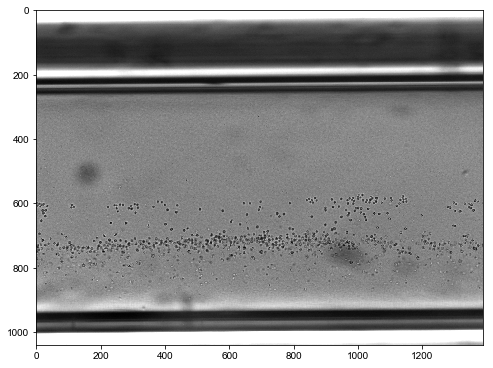

In [77]:
#Rotate image to parallel using scipy ndimage if needed (keep at 0 if already parallel)
rot_ang = 0 #degrees of rotation

rot = ndimage.rotate(grey, rot_ang)
plt.figure(figsize = (8,8))
plt.imshow(rot, cmap = plt.get_cmap('gray'))

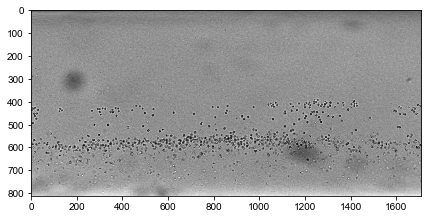

In [87]:
#Crop image to channel dimensions (removing extra space on top and bottom)
#Crop vertically using user-selected channel wall coordinates (depending on how the device was positioned for that image)
cropr_t = 260 #top
cropr_b = 650 + cropr_t #bottom; keep a difference of approx. 660
cropc_l = 10 #200 #left #200 for new m.
cropc_r = rot.shape[1]-10 #2400 #right #1200 for new m.
crop = rot[cropr_t:cropr_b,cropc_l:cropc_r]

#Choose one of the following resize settings, based on which microscope the image was captured on:
resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),int((cropc_r-cropc_l)*1.25))) #skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),1267)) #for old microscope
#resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*0.925),int((cropc_r-cropc_l)*0.925))) #for new microscope
#resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*0.690),int((cropc_r-cropc_l)*0.690))) #for new microscope
#resized = skimage.transform.resize(crop, (int((cropr_b-cropr_t)*2.3),int((cropc_r-cropc_l)*2.3))) #skimage.transform.resize(crop, (int((cropr_b-cropr_t)*1.25),1267)) #for old microscope

#Pixels in the image approximately correspond to microns in the device dimensions after image adjustment to account for different microscope cameras.
plt.figure(figsize = (7,7))
plt.imshow(resized, cmap = plt.get_cmap('gray'))

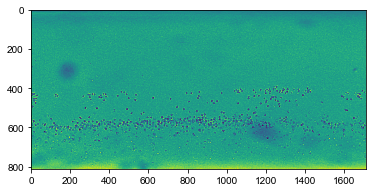

In [81]:
#Save the cropped image for current or future analysis
cropsav = cv2.convertScaleAbs(resized, alpha=(255.0))
cv2.imwrite("{}\{}_crop.tif".format(path,img_title), cropsav)

plt.imshow(cropsav)

In [82]:
#(Start here if working from a pre-cropped image)
#Import pre-cropped image
#img_title = 'Snap-18_c1'

#Convert to greyscale
img_bf = cv2.imread(os.path.join(path, img_title + "_crop.tif")) 
resized = cv2.cvtColor(img_bf, cv2.COLOR_BGR2GRAY)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
  """


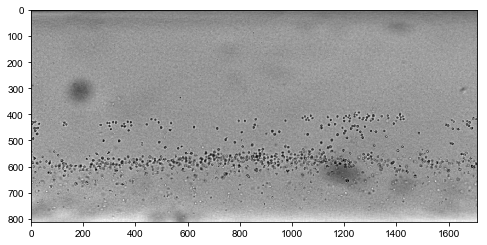

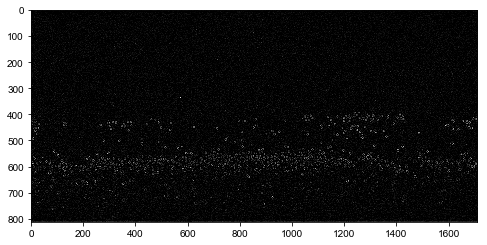

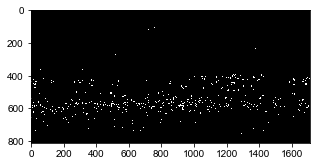

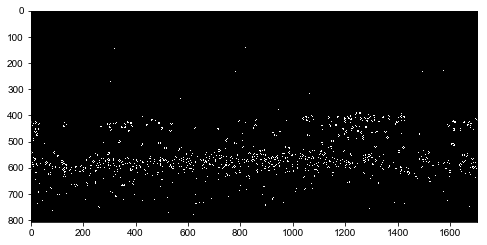

In [83]:
#Apply Gaussian smoothing 
blur = cv2.GaussianBlur(resized, (3,3), 2.7, 2.7)

from scipy.misc import bytescale
blur8 = bytescale(blur)
plt.figure(figsize = (8,8))
plt.imshow(blur8, cmap = plt.get_cmap('gray')) 

#Apply Laplacian filter 
smooth  = cv2.Laplacian(blur8, 8)
plt.figure(figsize = (8,8))
plt.imshow(smooth, cmap = plt.get_cmap('gray')) 

smooth = smooth.astype('uint8')

#Binarise using Otsu's thresholding by default (can use binary threshold if image distribution is significantly different)
#ret,th = cv2.threshold(smooth,0,1,cv2.THRESH_OTSU) #with Otsu's method, pos 2 is an arbitrary float (default: 0), pos 3 is the max value desired in output (1), pos 4 selects the thresholding fcn
ret,th = cv2.threshold(smooth,10,1,cv2.THRESH_BINARY) #with Otsu's method, pos 2 is an arbitrary float (default: 0), pos 3 is the max value desired in output (1), pos 4 selects the thresholding fcn

plt.figure(figsize = (5,5))
plt.imshow(th, cmap = plt.get_cmap('gray')) 

cropper=5 #remove edge of image where binarisation adds a contrasting border artifact
plt.figure(figsize = (8,8))
plt.imshow(th[0:th.shape[0]-cropper,0:th.shape[1]-cropper], cmap = plt.get_cmap('gray'))

#If non-cell debris/artifacts persist through the Laplacian filter, manually remove here by setting the affected rows to zero (if background should be empty/cell-free).
#th[0:20] = 0
th[780::] = 0
plt.figure(figsize = (10,10))
plt.imshow(th, cmap = plt.get_cmap('gray')) 

Peak height: (array([324], dtype=int64),)
[360.94374337] Mean
[7034.29533737] Variance
[352484.51788388] Skewness
[2.02035857e+08] Kurtosis


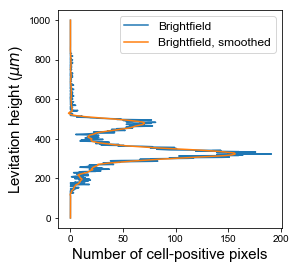

In [84]:
#Sum intensity values for each row (across the columns)
n_rowsb = th.shape[0]-cropper
intmatb = np.empty((n_rowsb,1))
#sums horizontally across each row
for i in range(0,n_rowsb):
    intmatb[i] = sum(th[i,0:th.shape[1]-cropper]) 
    
#Background noise subtraction (optional, for manual removal of artifacts)
#If non-cell debris/artifacts persist through the Laplacian filter, manually remove here by setting the affected rows to zero (if background should be empty/cell-free).
#intmatb[0:20] = 0
#intmatb[300:500] = 0
p_intmat = intmatb

p_intmat[0:2]=0 #removing border artifact

#Pad 100 on bottom, and approx. 100 on top to bring the total height to 1000 (very bottom and top of the capillary is obscured due to refraction at the glass interfact)
p_intmatpad = np.pad(p_intmat, [(0, int(0.5*(1000-th.shape[0]))+cropper), (0, 0)], mode='constant', constant_values=0)

#Flip vertically to place 0 at the bottom and 1000 on top
rev_intmatb = p_intmatpad[::-1]

#Pad top with zeros (approx. 100) to finalise array height to 1000
hts = np.pad(rev_intmatb, [(0, 1000-rev_intmatb.shape[0]), (0, 0)], mode='constant', constant_values=0)
#print hts.shape, 'Shape of array'

# Plot the cell height distribution

#Smoothing with Savitzky-Golay filter
hts_smooth = savgol_filter(hts[:,0], 87, 4) # window size, polynomial order

#Plot smoothed curve on top of raw data
plt.figure(figsize=(4,4))
plt.plot(hts[:,0], range(0,1000), markersize=2, label = "Brightfield")
plt.plot(hts_smooth, range(0,1000), markersize=2, label = "Brightfield, smoothed")
plt.xlabel('Number of cell-positive pixels', fontsize=15)
plt.ylabel('Levitation height (${\mu}m$)', fontsize=15)
plt.legend(fontsize=12)

#Peak height
index = np.where(hts_smooth == np.amax(hts_smooth))
print 'Peak height:', index

#Prepare height distribution for extraction of statistical moments
#Compute statistical metrics for the distribution (mean, variance, skewness, kurtosis)
data_arr = hts

#Statistical analysis of heights
multilist = [None]*data_arr.shape[1] #prepare empty list

#Loop through each height distribution
for i in range(0,data_arr.shape[1]):
    hlist = []
    count = 1
    heights = data_arr[:,i]
    for h in heights:
        hlist = hlist + [count]*int(h)
        count = count+1
    multilist[i]=hlist
    
#Store statistical descriptors of these height distributions: columns are different sample types;
#1. mean, 2. variance, 3. skewness (3rd statistical moment), 4. kurtosis (4th statistical moment)
multistat = np.empty([4,data_arr.shape[1]])
for i in range(0,data_arr.shape[1]):
    multistat[:,i] = [np.mean(multilist[i]), np.var(multilist[i]), moment(multilist[i],moment=3), moment(multilist[i],moment=4)] #, np.sqrt(np.var(jlist)), np.median(jlist)]

#Print the statistical metric outputs:
print multistat[0], "Mean"
print multistat[1], "Variance"
print multistat[2], "Skewness"
print multistat[3], "Kurtosis"

In [85]:
#Assign variables for temporary storage
hts1 = hts
ms1 = multistat

In [285]:
#Finally, save all variables into a csv file
hts_stack = np.column_stack((hts1, hts2, hts3, hts4, hts5, hts6, hts7, hts8, hts9, hts10, hts11, hts12, hts13, hts14)) 
yourfilename = str('hts4a_uninf')
np.savetxt('{}\{}.csv'.format(path,yourfilename), hts_stack, delimiter = ",") 

In [286]:
#Save all variables into a csv file
ms_stack_pre = np.column_stack((ms1, ms2, ms3, ms4, ms5, ms6, ms7, ms8, ms9, ms10, ms11, ms12, ms13, ms14)) 
ms_stack = np.transpose(ms_stack_pre)
yourfilename = str('ms4a_uninf')
np.savetxt('{}\{}.csv'.format(path,yourfilename), ms_stack, delimiter = ",") 